# Progetto di Data Mining 2.5 Clustering

## Pendigits Dataset Analysis and Processing

Importiamo le librerie che andremo ad utilizzare

In [1]:
#import Librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml

from utils.utils_functions import Utils_functions

Scarichiamo il Dataset

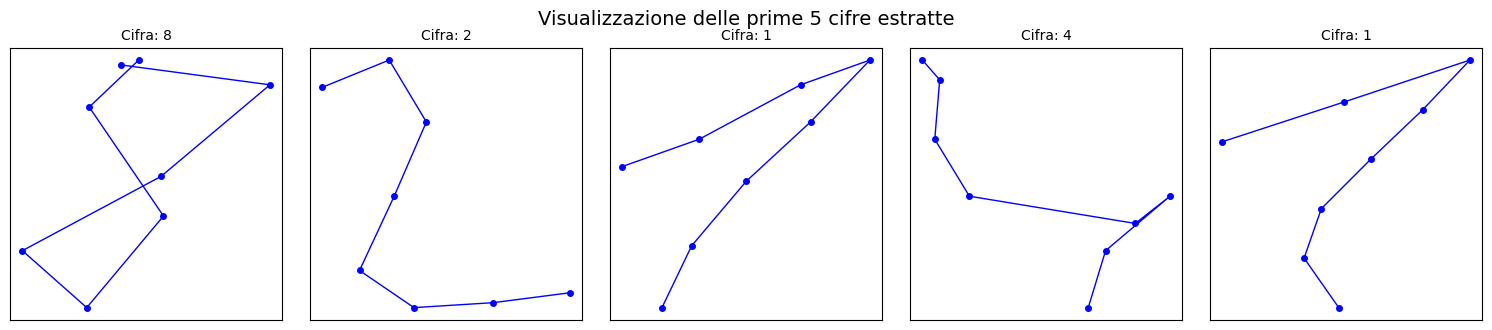

Il dataset non contiene valori mancanti
Numero di componenti necessarie per spiegare almeno il 90.0% della varianza: 7
Dataset PCA salvato in: ../data/processed/pendigits_pca.csv


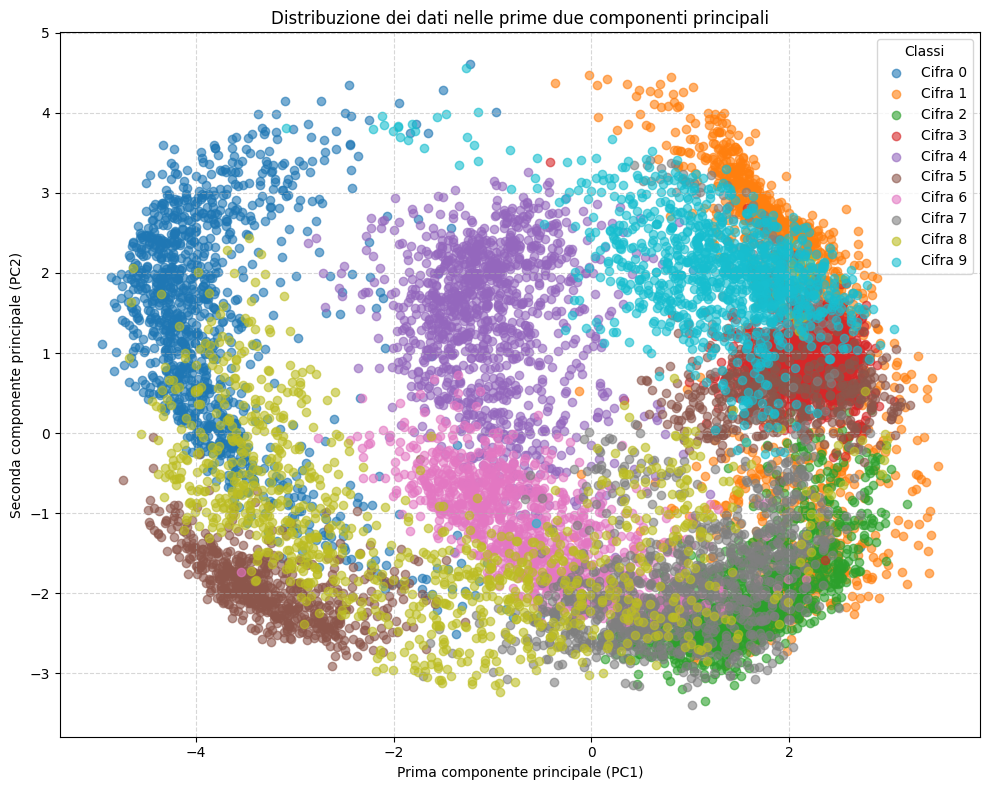

In [ ]:
#funzione per visualizzare un campione dei dati estratti con qualità per pubblicazione scientifica
def visualize_raw_data(X, y):
    # seleziono le prime 5 istanze
    indices = range(5)

    # imposto i sottografi con uno stile migliorato
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)

    # titolo principale in stile scientifico
    fig.suptitle('Visualizzazione delle prime 5 cifre estratte', fontsize=14, y=1.05)

    for i, index in enumerate(indices):
        instance = X.iloc[index].values
        digit = y.iloc[index]

        # estraggo le coordinate dei punti che formano la cifra
        x_coords = instance[::2]
        y_coords = instance[1::2]

        # disegno i punti che formano la cifra
        axes[i].plot(x_coords, y_coords, marker='o', color='blue', markersize=4, linewidth=1)
        axes[i].set_title(f'Cifra: {digit}', fontsize=10)
        axes[i].set_xticks([])  # rimuove le etichette sugli assi
        axes[i].set_yticks([])
        axes[i].set_aspect('equal')  # garantisce proporzioni uguali
        axes[i].grid(True, linestyle='--', alpha=0.4)
        plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

#funzione per effettuare il preprocessamento del dataset
def preprocessing_pipeline(X, y):    
    #verifichiamo la presenza di valori mancanti
    missing_counts = X.isnull().sum()
    if not missing_counts.any():
        print("Il dataset non contiene valori mancanti") 
    else: 
        print("Il dataset contiene valori mancanti")
    
    #standardizziamo il dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #ricreiamo il dataframe con le feature standardizzate
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled['target'] = y.reset_index(drop=True)

    #salviamo il dataset standardizzato in formato csv
    output_path = "../data/processed/pendigits_standardized.csv"
    df_scaled.to_csv(output_path, index=False)
    
    #applichiamo la pca per effettuare una feature extraction
    datasets, datasets_names, n_components = Utils_functions.process_data(X)
    
    #selezioniamo il numero di componenti che spiegano ~90% della varianza
    pca = PCA(n_components=n_components)
    X_pca_optimal = pca.fit_transform(X_scaled)

    #ricreiamo il dataframe con le feature estratte
    pca_columns = [f"PC{i+1}" for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca_optimal, columns=pca_columns)
    df_pca['target'] = y.reset_index(drop=True)

    #salviamo il dataset trasformato in formato csv
    output_path = "../data/processed/pendigits_pca.csv"
    df_pca.to_csv(output_path, index=False)
    print(f"Dataset PCA salvato in: {output_path}")

#funzione per visualizzare la distribuzione delle classi dopo la feature extraction
def visualize_pca_2d():
    #carichiamo il dataset PCA salvato
    df_pca = pd.read_csv("../data/processed/pendigits_pca.csv")

    #visualizziamo le prime due componenti principali, ordinando le classi
    plt.figure(figsize=(10, 8))
    for label in sorted(df_pca['target'].unique()):
        subset = df_pca[df_pca['target'] == label]
        plt.scatter(
            subset['PC1'],
            subset['PC2'],
            label=f'Cifra {label}',
            alpha=0.6
        )
    plt.title('Distribuzione dei dati nelle prime due componenti principali')
    plt.xlabel('Prima componente principale (PC1)')
    plt.ylabel('Seconda componente principale (PC2)')
    plt.legend(title="Classi")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#funzione per verificare, visualizzare gli outliers e la distribuzione delle features
def check_and_visualize_outliers_and_distribution():
    #carichiamo il dataset standardizzato
    df = pd.read_csv("../data/processed/pendigits_standardized.csv")
    X = df.drop(columns=["target"])
    
    #dizionario per salvare la presenza di outliers per ogni feature
    outlier_summary = {}

    #creazione della figura con due righe per ogni feature: boxplot e violin plot
    num_features = len(X.columns)
    plt.figure(figsize=(20, num_features * 3))
    plt.suptitle('Rilevazione Outliers e Distribuzione Dati', fontsize=18)

    for i, column in enumerate(X.columns):
        #calcolo dei valori di soglia per individuare gli outliers
        Q1 = X[column].quantile(0.25)
        Q3 = X[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        #conteggio degli outliers
        outliers = ((X[column] < lower_bound) | (X[column] > upper_bound)).sum()
        outlier_summary[column] = outliers

        #aggiunta del boxplot
        plt.subplot(num_features, 2, 2 * i + 1)
        sns.boxplot(x=X[column], color="skyblue")
        plt.title(f"Boxplot - {column} ({outliers} outliers)", fontsize=10)
        plt.xlabel("")
        plt.grid(True, linestyle='--', alpha=0.5)

        #aggiunta del violin plot
        plt.subplot(num_features, 2, 2 * i + 2)
        sns.violinplot(x=X[column], color="lightgreen")
        plt.title(f"Violin Plot - {column}", fontsize=10)
        plt.xlabel("")
        plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    #visualizzazione del riepilogo degli outliers
    print("Riepilogo degli Outliers:")
    for feature, count in outlier_summary.items():
        print(f"Feature {feature}: {count} outliers")

    #verifica se ci sono outliers
    total_outliers = sum(outlier_summary.values())
    if total_outliers > 0:
        print(f"Totale outliers rilevati: {total_outliers}")
    else:
        print("Non sono stati rilevati outliers nel dataset.")


X, y = Utils_functions.load_data()

visualize_raw_data(X, y)
preprocessing_pipeline(X, y)
visualize_pca_2d()

